In [2]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

### Experiment 1 - Uncoupled 3-box w/ and w/o noise

List of experiments:

a) 2xCO2

b) High Emissions

c) Overshoot

#### Setup and Run Experiments

In [249]:
# Ensemble parameters
n_ensemble = 50   # Ensemble members
xi = 0.3         # Noise strength

# Required variables
t_end, t_star = 251, 50
t = np.arange(0,t_end)
n_boxes = 5

# Initialize forcing vectors and run experiments
experiments = ['2xCO2','High Emissions','Overshoot']
full_outputs_ensemble, forcings_ensemble, T_out_ensemble = {}, {}, {}
full_outputs_single, forcings_single, T_out_single = {}, {}, {}

# Iterate over set of experiments
for i, exp in enumerate(experiments):
  full_outputs_ensemble[exp], forcings_ensemble[exp], T_out_ensemble[exp] = [], [] ,[]

  # Run deterministic experiments once
  full_outputs_single[exp] = BudykoSellers.Run_Budyko_Sellers(exp_flag=i)
  forcings_single[exp] = np.tile(full_outputs_single[exp]['forcing_ts'], (n_boxes, 1))
  T_out_single[exp] = np.squeeze(full_outputs_single[exp]['T_ts'])[0:n_boxes,:]

  # Iterate over all ensemble members
  for n in range(n_ensemble):
    full_outputs_ensemble[exp].append(BudykoSellers.Run_Budyko_Sellers(exp_flag=i, xi=xi))
    forcings_ensemble[exp].append(np.tile(full_outputs_ensemble[exp][-1]['forcing_ts'], (n_boxes, 1)))
    T_out_ensemble[exp].append(np.squeeze(full_outputs_ensemble[exp][-1]['T_ts'])[0:n_boxes,:])


100%|██████████| 22827/22827 [00:00<00:00, 35619.39it/s]
/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:308: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  # Set grid parameters
100%|██████████| 22827/22827 [00:00<00:00, 33773.65it/s]


### Method X: DMD

In [251]:
n_choices = 10
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1

operator_DMD, T_pred_DMD, L2_DMD = emulator_utils.emulate_experiments('DMD', experiments=experiments, outputs=T_out_single, forcings=forcings_single, w0=w0, t=t, dt=dt, n_steps=n_steps, n_boxes=n_boxes)
operator_ensemble_DMD, operator_L2_avg_DMD = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'DMD', operator_DMD)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 0.054332869442648715
	Test: High Emissions - 0.7985972306372324
	Test: Overshoot - 0.49775667591844436
Train: High Emissions - L2 Error
	Test: 2xCO2 - 1.2314026993142293
	Test: High Emissions - 0.0008424351639782824
	Test: Overshoot - 0.7689126804802296
Train: Overshoot - L2 Error
	Test: 2xCO2 - 2.054417415638113
	Test: High Emissions - 0.03155307402036834
	Test: Overshoot - 0.0006242231570004145


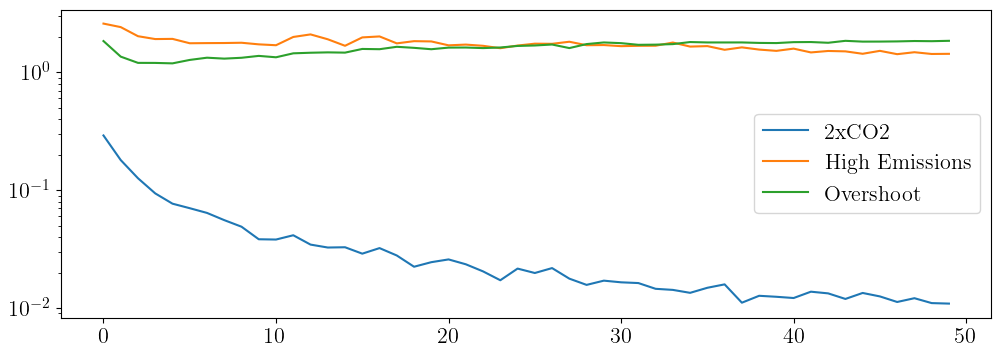

In [253]:
for exp in experiments:
  plt.semilogy(operator_L2_avg_DMD[exp], label=exp)
plt.legend()

### Method X: EDMD

In [254]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
w_dict = emulator_utils.Vector_Dict(method='polynomial', degree=1)
F_dict = emulator_utils.Vector_Dict(method='polynomial', degree=1)
operator_EDMD, T_pred_EDMD, L2_EDMD = emulator_utils.emulate_experiments('EDMD', experiments=experiments, outputs=T_out_single, forcings=forcings_single, w0=w0, t=t, dt=dt,
                                                                n_steps=n_steps, n_boxes=n_boxes, w_dict=w_dict, F_dict=F_dict)
#emulator_utils.plot_true_pred(T_out_single, T_pred_EDMD, experiments)
operator_ensemble_EDMD, operator_L2_avg_EDMD = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'EDMD', operator_EDMD, w_dict=w_dict, F_dict=F_dict)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 0.05433286944246475
	Test: High Emissions - 1.4987624041664487
	Test: Overshoot - 1.117189631357224
Train: High Emissions - L2 Error
	Test: 2xCO2 - 1.2842714037483653
	Test: High Emissions - 0.000842160115637447
	Test: Overshoot - 0.7793278812959085
Train: Overshoot - L2 Error
	Test: 2xCO2 - 2.045896230377219
	Test: High Emissions - 0.031549016065244115
	Test: Overshoot - 0.0005565906876687175


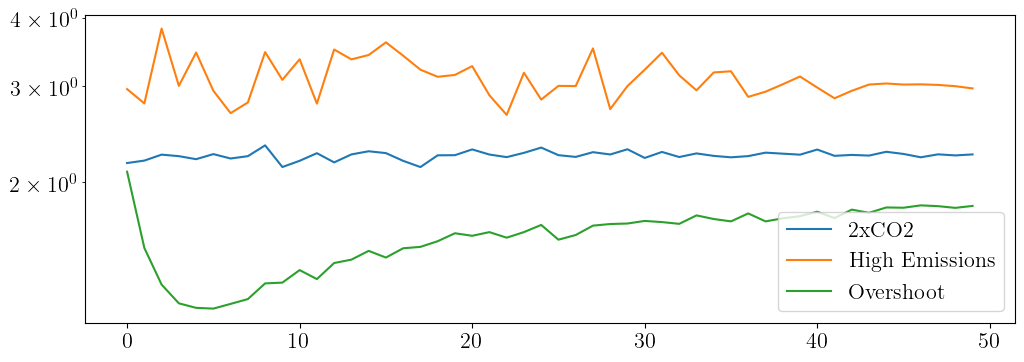

In [255]:
for exp in experiments:
  plt.semilogy(operator_L2_avg_EDMD[exp], label=exp)
plt.legend()

### Method X: Deconvolution

In [256]:
n_steps = len(t)
w0 = np.zeros(n_boxes)
dt = 1
operator_deconvolve, T_pred_deconvolve, L2_deconvolve = emulator_utils.emulate_experiments('deconvolve', experiments=experiments, outputs=T_out_single, forcings=forcings_single, dt=dt)
#emulator_utils.plot_true_pred(T_out, T_pred_deconvolve, experiments)
operator_ensemble_deconvolve, operator_L2_avg_deconvolve = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'deconvolve', operator_deconvolve, dt=dt)

Train: 2xCO2 - L2 Error
	Test: 2xCO2 - 2.843643763486786e-14
	Test: High Emissions - 0.7785810586866767
	Test: Overshoot - 0.48668944674607506
Train: High Emissions - L2 Error
	Test: 2xCO2 - 1.2027675833327827
	Test: High Emissions - 4.2218392726804337e-14
	Test: Overshoot - 0.7516548455691935
Train: Overshoot - L2 Error
	Test: 2xCO2 - 1359175.4480164354
	Test: High Emissions - 22412.658966528692
	Test: Overshoot - 6.070369566042452e-14


/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:733: RuntimeWarning: overflow encountered in multiply
  x = x * invdiag


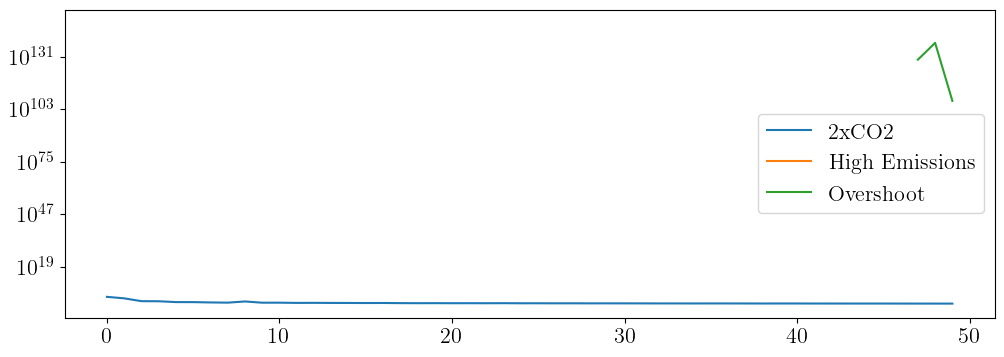

In [257]:
for exp in experiments:
  plt.semilogy(operator_L2_avg_deconvolve[exp], label=exp)
plt.legend()

### Method X: Direct Diagnosis

In [193]:
n_ensemble = 50
operator_direct, T_pred_direct, L2_direct = emulator_utils.emulate_experiments('direct', experiments=experiments, outputs=T_out_single, forcings=forcings_single, n_boxes=n_boxes, dt=dt)
#emulator_utils.plot_true_pred_direct(T_out, T_pred_direct, experiments)
operator_ensemble_direct, operator_L2_avg_direct = emulator_utils.evaluate_ensemble(experiments, n_ensemble, n_choices, forcings_ensemble, T_out_ensemble, 'direct', operator_direct, t=t, dt=dt, n_boxes=n_boxes, xi=xi)

100%|██████████| 22827/22827 [00:00<00:00, 33474.50it/s]


Train: Impulse Forcing - L2 Error
	Test: 2xCO2 - 1.5730398636794063
	Test: High Emissions - 0.26961399061701136
	Test: Overshoot - 0.9335296520994525


100%|██████████| 22827/22827 [00:00<00:00, 35798.25it/s]
/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:299: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  def Run_Budyko_Sellers(exp_flag=0, diff_flag=0, vert_diff_flag=0, xi=0):
100%|██████████| 22827/22827 [00:00<00:00, 35131.16it/s]


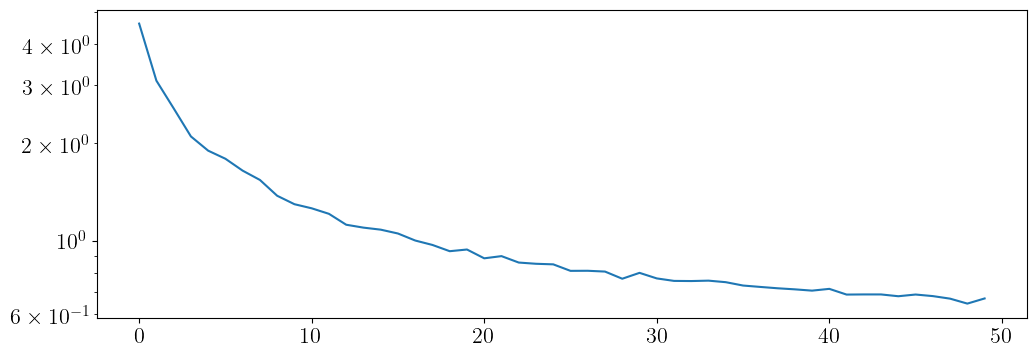

In [194]:
plt.semilogy(operator_L2_avg_direct, label=exp)

### Method X: FDT

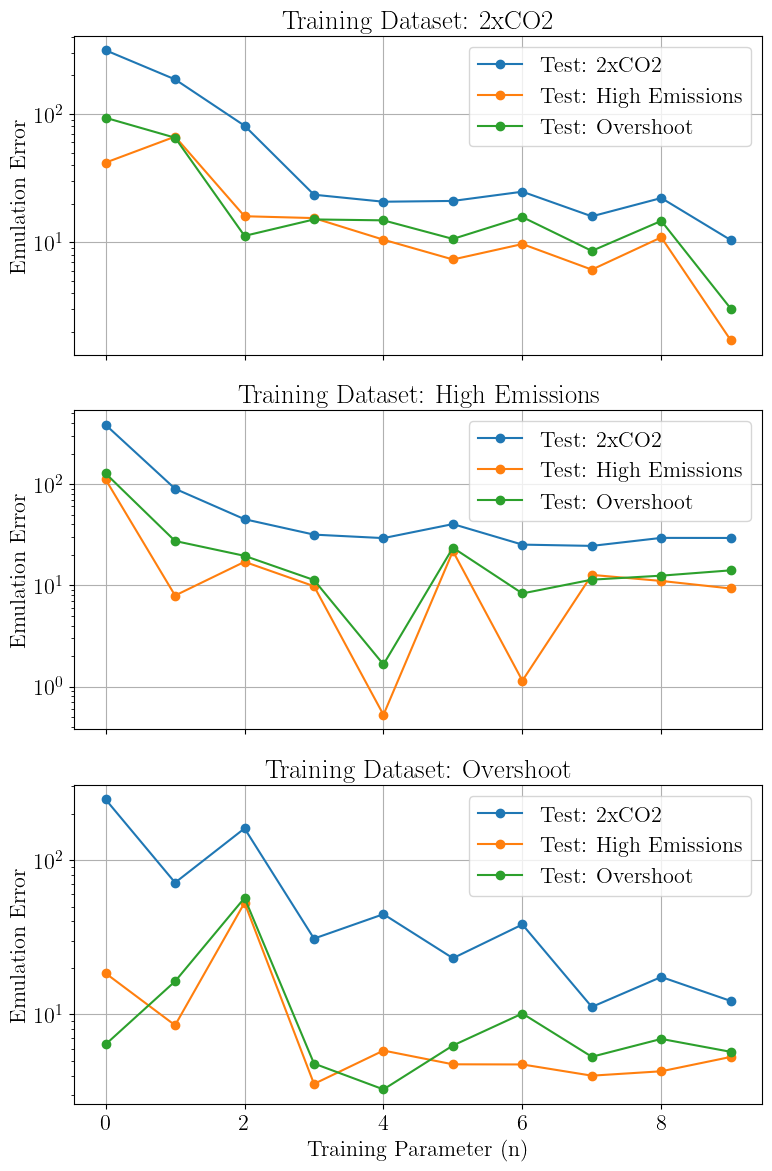

In [243]:
# Number of subplots
num_subplots = len(train_datasets)
n_values = np.arange(len(L2_FDT))  # Indices represent the training parameter n

# Create subplots
fig, axes = plt.subplots(nrows=num_subplots, figsize=(8, 4 * num_subplots), sharex=True)

if num_subplots == 1:
  axes = [axes]  # Ensure axes is iterable if there's only one subplot

for i, exp1 in enumerate(experiments):
  ax = axes[i]
  for exp2 in experiments:
    errors = [entry[exp1][exp2] for entry in L2_FDT]
    ax.semilogy(n_values, errors, marker='o', label=f'Test: {exp2}')

  ax.set_title(f'Training Dataset: {exp1}')
  ax.set_ylabel('Emulation Error')
  ax.legend()
  ax.grid(True)

# Common x-axis label
axes[-1].set_xlabel('Training Parameter (n)')

# Show plot
plt.tight_layout()
plt.show()

Train: 2xCO2 - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 35322.52it/s]
/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:308: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  # Set grid parameters
100%|██████████| 22827/22827 [00:00<00:00, 34841.59it/s]


	Test: 2xCO2 - 314.46374399630236
	Test: High Emissions - 41.81329810430844
	Test: Overshoot - 93.50516690578606
Train: High Emissions - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36045.20it/s]


	Test: 2xCO2 - 383.7682699524735
	Test: High Emissions - 110.8851898083563
	Test: Overshoot - 127.12531885530494
Train: Overshoot - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 35866.36it/s]


	Test: 2xCO2 - 246.85210856136212
	Test: High Emissions - 18.47114775703118
	Test: Overshoot - 6.3985480062897695
Train: 2xCO2 - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36457.04it/s]


	Test: 2xCO2 - 186.3490974049094
	Test: High Emissions - 66.67699163660897
	Test: Overshoot - 65.37557581797358
Train: High Emissions - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 32100.20it/s]


	Test: 2xCO2 - 89.77693209152652
	Test: High Emissions - 7.9271367341585
	Test: Overshoot - 27.38111638041706
Train: Overshoot - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 35860.27it/s]


	Test: 2xCO2 - 71.3813972129941
	Test: High Emissions - 8.509111012574806
	Test: Overshoot - 16.381074691408987
Train: 2xCO2 - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 31968.53it/s]


	Test: 2xCO2 - 81.1278904380778
	Test: High Emissions - 15.956793447823099
	Test: Overshoot - 11.20927685452029
Train: High Emissions - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36030.13it/s]


	Test: 2xCO2 - 44.94193468084946
	Test: High Emissions - 17.05829796431291
	Test: Overshoot - 19.545246965576652
Train: Overshoot - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 26559.21it/s]


	Test: 2xCO2 - 160.30684018105495
	Test: High Emissions - 52.894250380493396
	Test: Overshoot - 56.85958871227779
Train: 2xCO2 - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 27384.10it/s]


	Test: 2xCO2 - 23.486738532743704
	Test: High Emissions - 15.433568536518617
	Test: Overshoot - 15.064330736417503
Train: High Emissions - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 34480.67it/s]


	Test: 2xCO2 - 31.65478670010825
	Test: High Emissions - 9.79466428790704
	Test: Overshoot - 11.272880823776775
Train: Overshoot - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36117.02it/s]


	Test: 2xCO2 - 30.988335390142137
	Test: High Emissions - 3.54694338064813
	Test: Overshoot - 4.805924707973166
Train: 2xCO2 - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36137.53it/s]


	Test: 2xCO2 - 20.70702539402728
	Test: High Emissions - 10.468786889400423
	Test: Overshoot - 14.819963030070578
Train: High Emissions - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 35818.01it/s]


	Test: 2xCO2 - 29.24247422395293
	Test: High Emissions - 0.5263861672790725
	Test: Overshoot - 1.654968949321059
Train: Overshoot - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36006.54it/s]


	Test: 2xCO2 - 44.601583977372876
	Test: High Emissions - 5.834990683402689
	Test: Overshoot - 3.268714993229852
Train: 2xCO2 - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 35396.68it/s]


	Test: 2xCO2 - 21.004983005620108
	Test: High Emissions - 7.3384274287929525
	Test: Overshoot - 10.613816735001294
Train: High Emissions - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36420.69it/s]


	Test: 2xCO2 - 40.225413172425284
	Test: High Emissions - 21.732420724178493
	Test: Overshoot - 23.5105301895965
Train: Overshoot - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 27702.60it/s]


	Test: 2xCO2 - 23.13391648469819
	Test: High Emissions - 4.752645038573773
	Test: Overshoot - 6.290766514704888
Train: 2xCO2 - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36557.30it/s]


	Test: 2xCO2 - 24.795478595033057
	Test: High Emissions - 9.683094799032242
	Test: Overshoot - 15.714135298122171
Train: High Emissions - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36679.66it/s]


	Test: 2xCO2 - 25.221893050016053
	Test: High Emissions - 1.1438003659652507
	Test: Overshoot - 8.312650288794835
Train: Overshoot - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36533.43it/s]


	Test: 2xCO2 - 38.23954085762705
	Test: High Emissions - 4.742369321239031
	Test: Overshoot - 10.135832256587442
Train: 2xCO2 - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36473.20it/s]


	Test: 2xCO2 - 15.928123471535624
	Test: High Emissions - 6.114447190032879
	Test: Overshoot - 8.559458015249058
Train: High Emissions - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36622.63it/s]


	Test: 2xCO2 - 24.501336389666424
	Test: High Emissions - 12.672596783291146
	Test: Overshoot - 11.36822899783797
Train: Overshoot - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36518.52it/s]


	Test: 2xCO2 - 11.184597647243812
	Test: High Emissions - 4.012097378484141
	Test: Overshoot - 5.318049069417706
Train: 2xCO2 - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36358.64it/s]


	Test: 2xCO2 - 22.13134604169558
	Test: High Emissions - 10.92060903556299
	Test: Overshoot - 14.675471744313887
Train: High Emissions - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36494.70it/s]


	Test: 2xCO2 - 29.38902858078726
	Test: High Emissions - 11.043213149006904
	Test: Overshoot - 12.451806268242398
Train: Overshoot - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36506.43it/s]


	Test: 2xCO2 - 17.48335846859721
	Test: High Emissions - 4.283749530726284
	Test: Overshoot - 6.9402651227942105
Train: 2xCO2 - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36339.00it/s]


	Test: 2xCO2 - 10.397368370295135
	Test: High Emissions - 1.7203683257014226
	Test: Overshoot - 3.0368654823501595
Train: High Emissions - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36172.42it/s]


	Test: 2xCO2 - 29.34276101826834
	Test: High Emissions - 9.302437283863801
	Test: Overshoot - 14.05234968825027
Train: Overshoot - L2 Error


100%|██████████| 22827/22827 [00:00<00:00, 36169.68it/s]


	Test: 2xCO2 - 12.225350082747426
	Test: High Emissions - 5.304393389005628
	Test: Overshoot - 5.724822606257281


TypeError: unhashable type: 'dict'

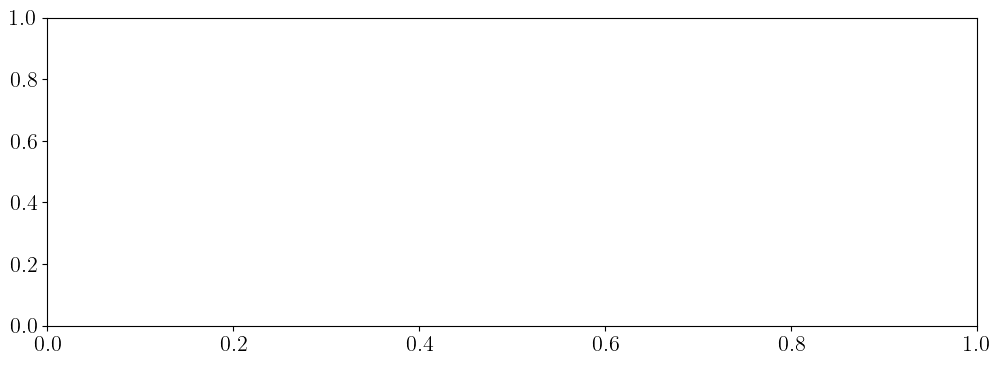

In [230]:
n_ensemble = 5
operator_FDT, T_pred_FDT, L2_FDT = [], [], []
delta_vec = np.arange(1,11,1)
for delta in delta_vec:
  operator_FDT_n, T_pred_FDT_n, L2_FDT_n = emulator_utils.emulate_experiments('FDT', experiments=experiments, forcings=forcings_single, outputs=T_out_single, n_ensemble=n_ensemble, n_boxes=n_boxes, n_steps=n_steps, xi=xi, delta=delta, dt=dt)

  operator_FDT.append(operator_FDT_n)
  T_pred_FDT.append(T_pred_FDT_n)
  L2_FDT.append(L2_FDT_n)

### Method X: Exponential Fit

Train: 2xCO2 - L2 Error
Exponential Fit Results:
 [  42.58759338  363.40770065  -13.17022061 -124.72538597  -33.83855197
 -297.03581553   -0.78137829   -0.78017135]
	Test: 2xCO2 - 14.823548379663473
	Test: High Emissions - 11.208183857646254
	Test: Overshoot - 8.881378895354436
Train: High Emissions - L2 Error
Exponential Fit Results:
 [ 0.53610006 -0.02327916  1.57196556  0.71754098  0.02476957  0.6718183
 -0.5829879  -0.92518196]
	Test: 2xCO2 - 21.762411623972977
	Test: High Emissions - 0.12952741822841052
	Test: Overshoot - 5.4937209786066115
Train: Overshoot - L2 Error
Exponential Fit Results:
 [ 0.35042857  0.16105175  1.43693308  0.60390633  0.62050815  0.23902337
 -0.93020788 -0.2986362 ]
	Test: 2xCO2 - 19.26846545600725
	Test: High Emissions - 3.2565744387932836
	Test: Overshoot - 4.864326045514617


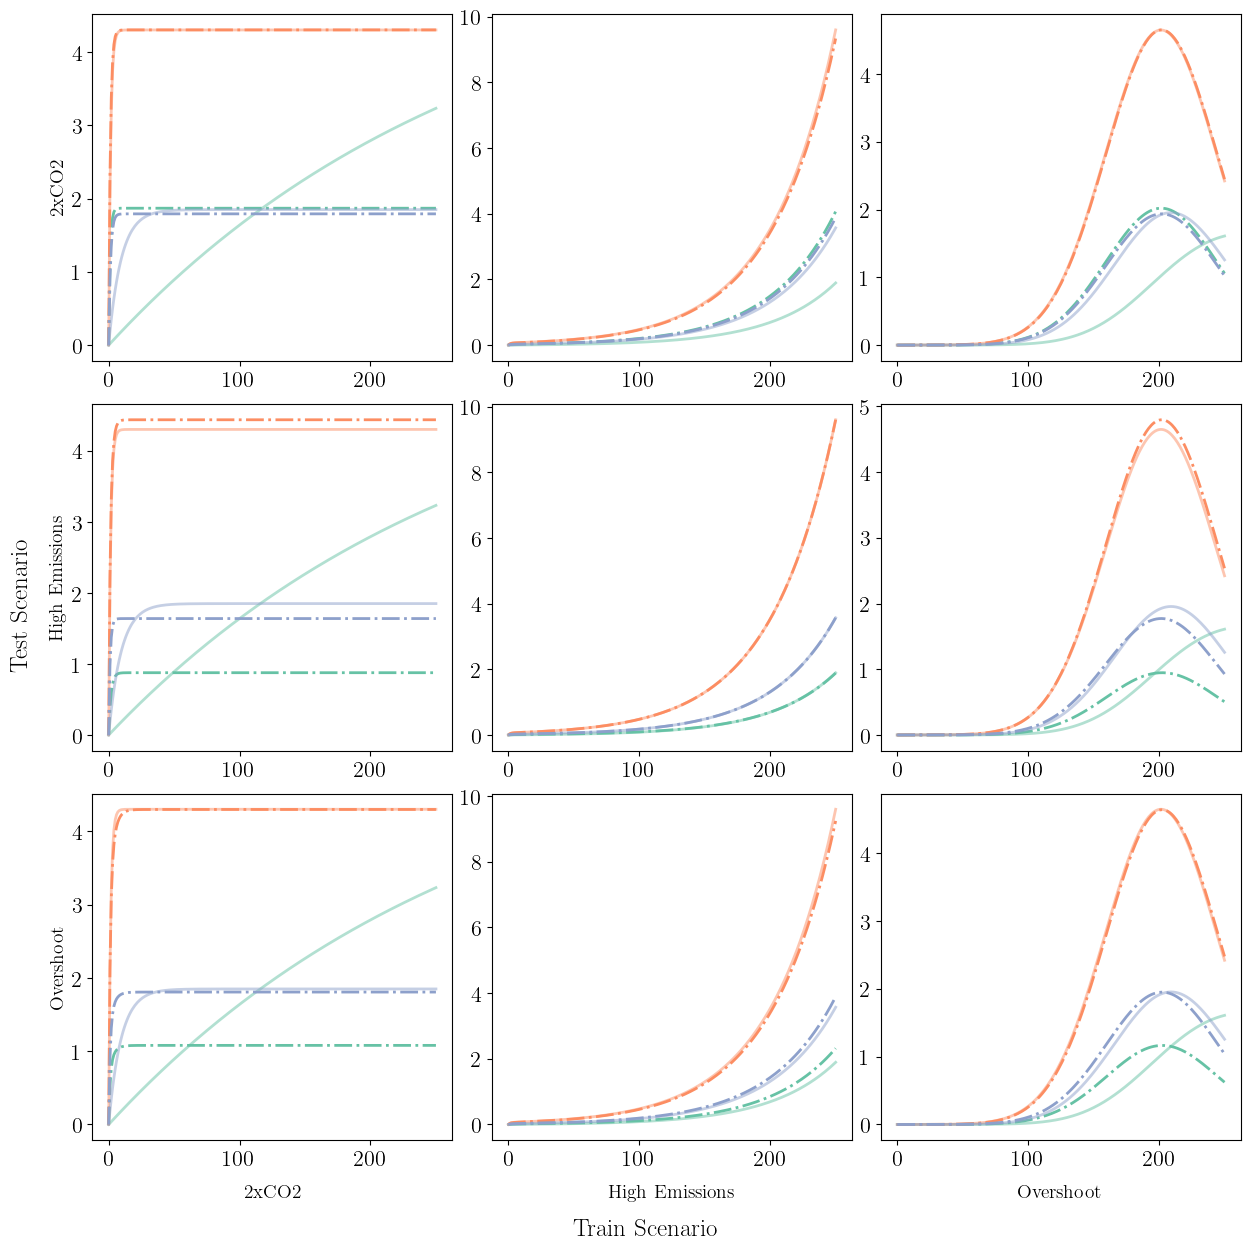

In [221]:
operator_fit, T_pred_fit = emulator_utils.emulate_experiments(experiments, T_out, forcings, 'fit', w0, t, dt, n_steps, n_boxes, n_modes=2)
emulator_utils.plot_true_pred(T_out, T_pred_fit, experiments)